In [525]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [526]:
df = pd.read_csv('df_with_emotions.csv')

In [527]:
df["Gender"] = le.fit_transform(df["Gender"])
df.head()

,Student_ID,Age,Gender,GPA,Stress_Level,Anxiety_Score,Depression_Score,Daily_Reflections,Sleep_Hours,Steps_Per_Day,...,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,negative,positive
0,1,1.159999,2,-0.566791,1.354829,1.607159,-0.916966,Onto foreign do environmental anyone every nea...,0.483148,-0.963883,...,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,5.918226,-1.297918
1,2,-0.601579,1,-0.138201,1.354829,-1.074594,-0.796598,Party but others visit admit industry country ...,-0.633426,-0.566872,...,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,-0.558704,2.905716
2,3,0.279210,0,1.400826,1.354829,0.187407,1.249664,Religious sure wait do chance decade according...,1.468360,0.793510,...,-0.589006,-0.403906,0.977859,-0.959785,2.005550,-0.401565,-0.739343,0.000000,1.060529,-0.247009
3,4,-1.041973,1,-1.501896,0.655743,0.818408,0.045981,A task effect entire coach join series.,1.402679,-0.263157,...,-0.589006,-0.403906,-0.754115,1.588991,-0.409189,-0.401565,-0.739343,0.000000,-0.558704,0.803899
4,5,-0.601579,2,0.115057,-1.441515,-1.232344,-1.157703,Knowledge several camera wait week write quali...,-0.107979,-1.201176,...,-0.589006,0.271686,0.311715,-0.175546,0.333807,-0.401565,0.895866,0.076923,0.437747,-0.651205


In [528]:
X = df.drop(columns=['Mental_Health_Status', 'Daily_Reflections', 'Student_ID']) #drop the target column and unrelated columns in the input set
Y = df["Mental_Health_Status"] #output
X.head()

,Age,Gender,GPA,Stress_Level,Anxiety_Score,Depression_Score,Sleep_Hours,Steps_Per_Day,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,negative,positive
0,1.159999,2,-0.566791,1.354829,1.607159,-0.916966,0.483148,-0.963883,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,5.918226,-1.297918
1,-0.601579,1,-0.138201,1.354829,-1.074594,-0.796598,-0.633426,-0.566872,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,-0.558704,2.905716
2,0.279210,0,1.400826,1.354829,0.187407,1.249664,1.468360,0.793510,-0.589006,-0.403906,0.977859,-0.959785,2.005550,-0.401565,-0.739343,0.000000,1.060529,-0.247009
3,-1.041973,1,-1.501896,0.655743,0.818408,0.045981,1.402679,-0.263157,-0.589006,-0.403906,-0.754115,1.588991,-0.409189,-0.401565,-0.739343,0.000000,-0.558704,0.803899
4,-0.601579,2,0.115057,-1.441515,-1.232344,-1.157703,-0.107979,-1.201176,-0.589006,0.271686,0.311715,-0.175546,0.333807,-0.401565,0.895866,0.076923,0.437747,-0.651205


In [529]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
model = RandomForestClassifier(random_state=42) #plot the parameters to find the best fit
param_grid = {
    'n_estimators': [10, 50, 100, 150],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 7],
}

In [530]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [3, 5, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [10, 50, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,100


In [531]:
results = pd.DataFrame(grid_search.cv_results_)

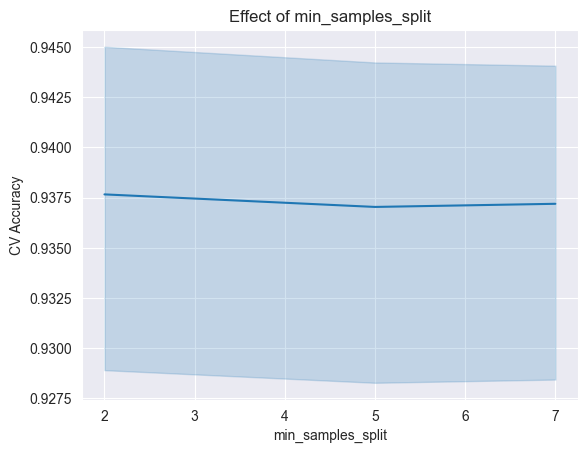

In [532]:
sns.lineplot(x='param_min_samples_split', y='mean_test_score', data=results)
plt.title("Effect of min_samples_split")
plt.ylabel("CV Accuracy")
plt.xlabel("min_samples_split")
plt.show()

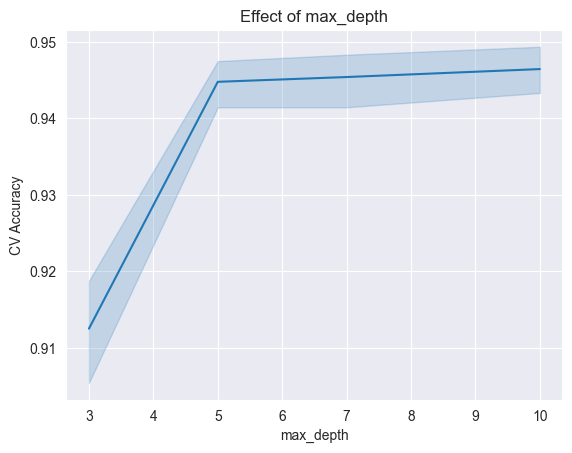

In [533]:
sns.lineplot(x='param_max_depth', y='mean_test_score', data=results)
plt.title("Effect of max_depth")
plt.ylabel("CV Accuracy")
plt.xlabel("max_depth")
plt.show()

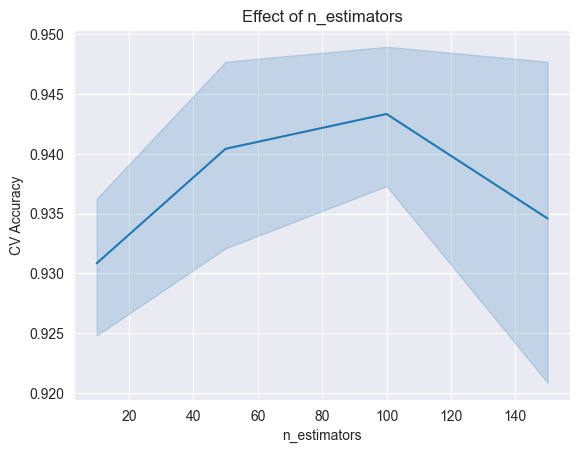

In [534]:
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=results)
plt.title("Effect of n_estimators")
plt.ylabel("CV Accuracy")
plt.xlabel("n_estimators")
plt.show()

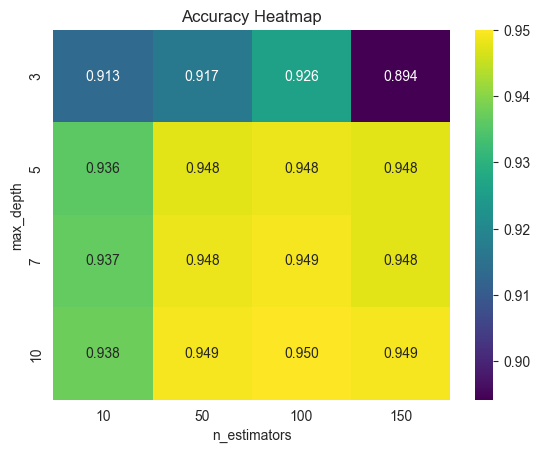

In [535]:
pivot = results.pivot_table(index='param_max_depth',
                             columns='param_n_estimators',
                             values='mean_test_score')

sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Accuracy Heatmap")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

In [536]:
model = RandomForestClassifier(random_state=42, max_depth = 5, min_samples_split = 5)

In [537]:
scores = cross_val_score(model, X, Y, cv= 10, scoring='accuracy')
print("Accuracy scores for each fold:", scores)
print("Average accuracy:", scores.mean())

Accuracy scores for each fold: [0.96 0.94 0.94 0.96 0.96 0.96 0.96 0.96 0.96 0.96]
Average accuracy: 0.9559999999999998


In [538]:
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [539]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.97


In [540]:
# Random Forest - actual training accuracy values
# [% of data used to train, accuracy value, changed parameter values]
# 70% - 0.96
# 70% - 0.953 - max_depth = 7, min_samples_split = 5
# 70% - 0.953 - max_depth = 5, min_samples_split = 5
# 70% - 0.946 - max_depth = 5
# 75% - 0.96
# 75% - 0.96 - max_depth = 10
# 80% - 0.97
# 80% - 0.97 - max_depth = 7, min_samples_split = 5
# 80% - 0.97 - max_depth = 5, min_samples_split = 5
# 80% - 0.97 - max_depth = 10, min_samples_split = 5
# 80% - 0.97 - max_depth = 5
# 85% - 0.9866666666666667
# 85% - 0.952 - max_depth = 5, min_samples_split = 5
# 85% - 0.96 - max_depth = 5
# 90% - 1.0
# 90% - 1.0 - max_depth = 10, n_estimators = 10

# Random Forest - cross validation training accuracy values
# [% of data used to train, accuracy value, changed parameter values]
# 70% - 0.9559999999999998
# 70% - 0.954 - max_depth = 7, min_samples_split = 5
# 70% - 0.9559999999999998 - max_depth = 5, min_samples_split = 5
# 70% - 0.952 - max_depth = 5
# 75% - 0.9559999999999998
# 75% - 0.954 - max_depth = 10
# 80% - 0.9559999999999998
# 80% - 0.954 - max_depth = 7, min_samples_split = 5
# 80% - 0.9559999999999998 - max_depth = 5, min_samples_split = 5
# 80% - 0.9559999999999998 - max_depth = 10, min_samples_split = 5
# 80% - 0.952 - max_depth = 5
# 85% - 0.9559999999999998
# 85% - 0.9559999999999998 - max_depth = 5, min_samples_split = 5
# 85% - 0.952 - max_depth = 5
# 90% - 0.9559999999999998
# 90% - 0.95 - max_depth = 10, n_estimators = 10

# min_samples_split default value = 2
# n_estimators default value = 100
# max_depth default value = None
# random_state for all = 42

# Best: 80% training, max_depth = 5, min_samples_split = 5